In [1]:
# VARIABLE DESCRIPTIONS:
# 1  survival        Survival
#                    (0 = No; 1 = Yes)
# 2  pclass          Passenger Class
#                    (1 = 1st; 2 = 2nd; 3 = 3rd)
# 3  name            Name
# 4  sex             Sex
# 5  age             Age
# 6  sibsp           Number of Siblings/Spouses Aboard
# 7  parch           Number of Parents/Children Aboard
# 8  ticket          Ticket Number
# 9  fare            Passenger Fare
# 10 cabin           Cabin
# 11 embarked        Port of Embarkation
#                    (C = Cherbourg; Q = Queenstown; S = Southampton)

In [2]:
%matplotlib inline
%config IPCompleter.greedy=True

import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd

In [3]:
train_path='./train.csv'
test_path='./test.csv'

# import data
traindf_raw = pd.read_csv(train_path)
testdf_raw = pd.read_csv(test_path)

In [4]:
from titanic_fun import *

# Clean the training values
traindf=clean_data(traindf_raw)
testdf=clean_data(testdf_raw)

/Users/Gambero/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:257: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [5]:
#CatVar=['Pclass','Sex','Embarked','NumCabins','Title','CabinNew','AgeBinned','FareBinned']
#ScaleVar=['SibSp','Parch','FamSize']
#NormVar=['Age','Log10Fare','FareAgeRatio','FareFam','AgeClassInt']
    
CatVar=['Pclass','Sex','Embarked','CabinNew','Title','FareBinned']
ScaleVar=['SibSp','Parch','FamSize']
NormVar=['FareAgeRatio','FareFam','AgeClassInt','Age']    

traindf=NewFeatures(traindf)
Xdf=preprocessFeatures(traindf,CatVar,ScaleVar,NormVar)

testdf=NewFeatures(testdf)
X_testdf=preprocessFeatures(testdf,CatVar,ScaleVar,NormVar)

X,X_test,labels=FeaturesNumpy(Xdf,X_testdf)

# Survivors
y=np.squeeze(traindf['Survived'].as_matrix())

In [6]:
from sklearn.cross_validation import train_test_split

# Split the dataset in two equal parts
X_train, X_cvtest, y_train, y_cvtest = train_test_split(X, y, test_size=0.005, random_state=42)

In [7]:
# number of training examples and features
m,n=np.shape(X_train)
print('m =',m,'n=',n)

m = 886 n= 36


In [8]:
# Null accuracy
null_accuracy=1-y.mean()

print('Null accuracy',null_accuracy)

Null accuracy 0.616161616162


In [9]:
# Grid search CV
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.learning_curve import validation_curve


def DoGridSearch(estimator,tuned_parameters,X,y,X_test,y_test):
    print("# Tuning hyper-parameters for accuracy")
    print()

    clf = GridSearchCV(estimator, tuned_parameters, cv=10,
                           scoring='accuracy',n_jobs=4)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
                  % (mean_score, scores.std() * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    
    return clf;

from sklearn.learning_curve import validation_curve

def DoValidationCurve(estimator,param_name,param_range,X,y):

    train_scores, test_scores = validation_curve(estimator, X, y,
                                                 param_name=param_name, param_range=param_range,
                                                 cv=10, scoring="accuracy", n_jobs=4)

    # Compute mean and std
    train_scores_mean=np.mean(train_scores, axis=1)
    train_scores_std=np.std(train_scores, axis=1)
    test_scores_mean=np.mean(test_scores, axis=1)
    test_scores_std=np.std(test_scores, axis=1)

    # Plot validation curve
    plt.figure(figsize=(10,6))
    plt.title("Validation Curve with "+str(estimator))
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.5, 0.95)

    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cv score", color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    
    return

In [10]:
# Grid search CV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

####### SVM ##########
# Define C array
Cs=[0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1,3,6,10]
gammas=[0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1]

# Set the parameters by cross-validation
tuned_parameters = [{'C':Cs,
                    'gamma':gammas}]

svm1=DoGridSearch(SVC(),tuned_parameters,X_train,y_train,X_cvtest,y_cvtest)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 1, 'gamma': 0.1}

Grid scores on development set:

0.617 (+/-0.004) for {'C': 0.001, 'gamma': 0.001}
0.617 (+/-0.004) for {'C': 0.001, 'gamma': 0.003}
0.617 (+/-0.004) for {'C': 0.001, 'gamma': 0.006}
0.617 (+/-0.004) for {'C': 0.001, 'gamma': 0.01}
0.617 (+/-0.004) for {'C': 0.001, 'gamma': 0.03}
0.617 (+/-0.004) for {'C': 0.001, 'gamma': 0.06}
0.617 (+/-0.004) for {'C': 0.001, 'gamma': 0.1}
0.617 (+/-0.004) for {'C': 0.001, 'gamma': 0.3}
0.617 (+/-0.004) for {'C': 0.001, 'gamma': 0.6}
0.617 (+/-0.004) for {'C': 0.001, 'gamma': 1}
0.617 (+/-0.004) for {'C': 0.003, 'gamma': 0.001}
0.617 (+/-0.004) for {'C': 0.003, 'gamma': 0.003}
0.617 (+/-0.004) for {'C': 0.003, 'gamma': 0.006}
0.617 (+/-0.004) for {'C': 0.003, 'gamma': 0.01}
0.617 (+/-0.004) for {'C': 0.003, 'gamma': 0.03}
0.617 (+/-0.004) for {'C': 0.003, 'gamma': 0.06}
0.617 (+/-0.004) for {'C': 0.003, 'gamma': 0.1}
0.617 (+/-0.004) for {'C

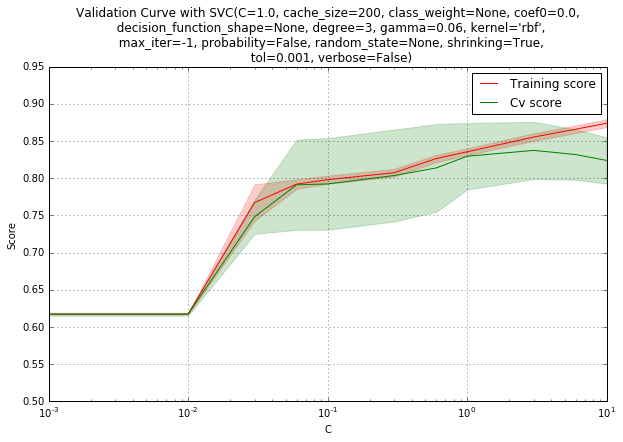

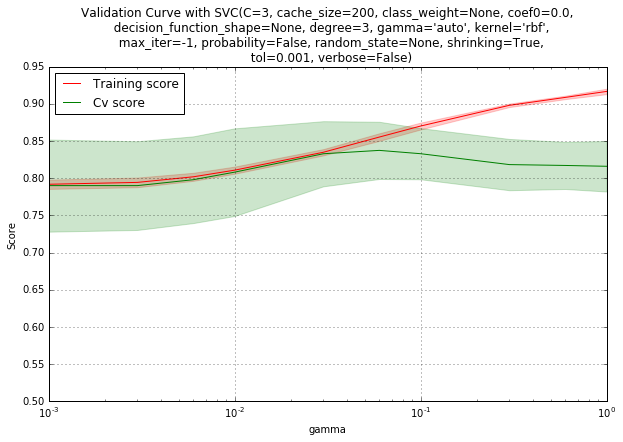

In [11]:
Cs=[0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1,3,6,10]
DoValidationCurve(SVC(gamma=0.06),'C',Cs,X_train,y_train)
DoValidationCurve(SVC(C=3),'gamma',gammas,X_train,y_train)

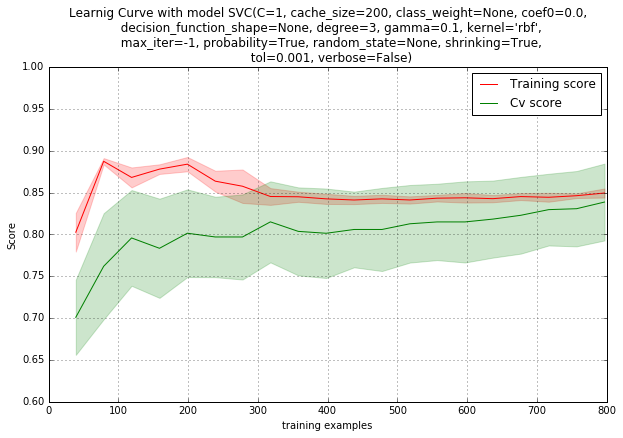

In [12]:
# Learning curves
from compare_models import *
model_1=SVC(**svm1.best_params_,probability=True)
model_1.fit(X_train,y_train)

# Compare the two models
models=[model_1]

CfrLearningCurves(models,X_train,y_train)

----------------------------- model_1 ------------------------------
Confusion matrix
[[502  45]
 [ 87 252]]
NullAccuracy:                      0.617381489842
Accuracy   : (TP+TN)/(TP+TN+FP+FN) 0.851015801354
Class Error: (FP+FN)/(TP+TN+FP+FN) 0.148984198646
Sensitivity:      TP/(TP+FN)       0.743362831858
Specificity:      TN/(TN+FP)       0.91773308958
FP rate    :      FP/(FP+TN)       0.0822669104205
Precision  :      TP/(FP+TP)       0.848484848485
F1 score   :                       0.792452830189
AUC        :                       0.903239984253



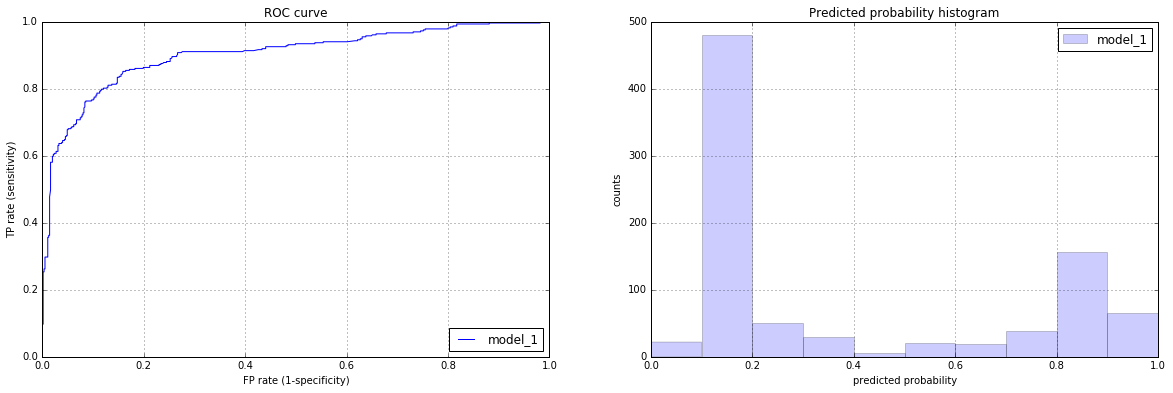

model_1 accuracy: 1.0


In [13]:
CfrROCCurves(models,X_train,y_train)

i=0
for model in models:
    i=i+1
    print('model_'+str(i)+' accuracy:',model.score(X_cvtest,y_cvtest))

In [14]:
# predictions for kaggle
y_pred_test_1=model_1.predict(X_test)
